### 1.1 Install Dependencies and Setup

!pip install labelme tensorflow tensorflow-gpu opencv-python matplotlib albumentations

### 1.2 Collecting Images Using OpenCV

In [2]:
import os
import time
import uuid
import cv2

In [28]:
IMAGES_PATH = os.path.join('D:/Project/Face_detection','images')
number_images = 30

In [29]:
cap = cv2.VideoCapture(0)
for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [8]:
IMAGES_PATH

'data\\images'

# 2. Review Dataset and Build Image Loading Function

### 2.1 Import TF and Deps

In [11]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

### 2.2 Limit GPU Memory Growth

In [12]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [13]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### 2.3 Load Image into TF Data Pipeline

In [30]:
images = tf.data.Dataset.list_files('D:\Project\Face_detection\\images\\*.jpg')

In [31]:
images.as_numpy_iterator().next()

b'D:\\Project\\Face_detection\\images\\7558cc42-503d-11ef-a4e6-b03cdce56770.jpg'

In [32]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [33]:
images = images.map(load_image)

In [34]:
images.as_numpy_iterator().next()

array([[[110, 121, 123],
        [110, 121, 123],
        [113, 124, 126],
        ...,
        [ 27,  44,  38],
        [ 24,  41,  35],
        [ 22,  39,  33]],

       [[112, 123, 125],
        [112, 123, 125],
        [114, 125, 127],
        ...,
        [ 25,  42,  36],
        [ 24,  41,  35],
        [ 23,  40,  34]],

       [[136, 148, 148],
        [134, 146, 146],
        [132, 144, 144],
        ...,
        [ 23,  42,  36],
        [ 25,  42,  36],
        [ 24,  41,  35]],

       ...,

       [[ 98,  22,  35],
        [ 99,  23,  36],
        [101,  23,  37],
        ...,
        [ 32,  55,  73],
        [ 31,  57,  74],
        [ 32,  58,  75]],

       [[ 99,  26,  37],
        [ 99,  26,  37],
        [102,  26,  39],
        ...,
        [ 31,  54,  72],
        [ 32,  55,  73],
        [ 32,  55,  73]],

       [[101,  28,  39],
        [101,  28,  39],
        [103,  27,  40],
        ...,
        [ 32,  55,  73],
        [ 32,  55,  73],
        [ 33,  56,  74]]

In [35]:
type(images)

tensorflow.python.data.ops.dataset_ops.MapDataset

### 2.4 View Raw Images with Matplotlib

In [36]:
image_generator = images.batch(4).as_numpy_iterator()

In [39]:
plot_images = image_generator.next()

# 3. Partition Unaugmented Data

### 3.1 MANUALLY Splitted DATA INTO TRAIN TEST AND VAL

### 3.2 Move the Matching Labels

In [42]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('D:/Project/Face_detection', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('D:/Project/Face_detection','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('D:/Project/Face_detection',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)      

# 4. Apply Image Augmentation on Images and Labels using Albumentations

### 4.1 Setup Albumentations Transform Pipeline

In [48]:
import albumentations as alb

In [49]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

### 4.2 Load a Test Image and Annotation with OpenCV and JSON

In [52]:
img = cv2.imread(os.path.join('D:/Project/Face_detection','train', 'images','73c2e80d-503d-11ef-97de-b03cdce56770.jpg'))

In [53]:
with open(os.path.join('D:/Project/Face_detection', 'train', 'labels', '73c2e80d-503d-11ef-97de-b03cdce56770.json'), 'r') as f:
    label = json.load(f)

In [54]:
label['shapes'][0]['points']

[[191.15384615384616, 105.38461538461542],
 [312.3076923076923, 272.6923076923077]]

### 4.3 Extract Coordinates and Rescale to Match Image Resolution

In [55]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [56]:
coords

[191.15384615384616, 105.38461538461542, 312.3076923076923, 272.6923076923077]

In [57]:
coords = list(np.divide(coords, [640,480,640,480]))

In [58]:
coords

[0.29867788461538464,
 0.2195512820512821,
 0.4879807692307693,
 0.5681089743589743]

### 4.4 Apply Augmentations and View Results

In [59]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [60]:
augmented['bboxes'][0][2:]

(0.414017094017094, 0.8191452991452991)

In [61]:
augmented['bboxes']

[(0.1447863247863248,
  0.4473504273504274,
  0.414017094017094,
  0.8191452991452991)]

# 5. Build and Run Augmentation Pipeline

### 5.1 Run Augmentation Pipeline

In [63]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('D:/Project/Face_detection', partition, 'images')):
        img = cv2.imread(os.path.join('D:/Project/Face_detection', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('D:/Project/Face_detection', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('D:/Project/Face_detection/aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('D:/Project/Face_detection/aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

x_max is less than or equal to x_min for bbox [0.19651442307692307, 0.4338942307692308, 0.0057091346153846315, 0.734375, 'face'].


### 5.2 Load Augmented Images to Tensorflow Dataset

In [64]:
train_images = tf.data.Dataset.list_files('D:\Project\Face_detection/aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [65]:
test_images = tf.data.Dataset.list_files('D:\Project\Face_detection/aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [67]:
val_images = tf.data.Dataset.list_files('D:\Project\Face_detection/aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [68]:
train_images.as_numpy_iterator().next()

array([[[0.56170344, 0.8793505 , 0.88327205],
        [0.5647059 , 0.88235295, 0.8862745 ],
        [0.57077205, 0.8884191 , 0.89234066],
        ...,
        [0.19981618, 0.40275735, 0.36599264],
        [0.19393383, 0.39767158, 0.35116422],
        [0.19215687, 0.39607844, 0.34810048]],

       [[0.55735296, 0.87892157, 0.87107843],
        [0.56078434, 0.88235295, 0.8745098 ],
        [0.5602941 , 0.88186276, 0.8740196 ],
        ...,
        [0.20343137, 0.41127452, 0.37303922],
        [0.20049019, 0.40833333, 0.3692402 ],
        [0.20392157, 0.40735295, 0.36421567]],

       [[0.5647059 , 0.88235295, 0.8862745 ],
        [0.5686275 , 0.8862745 , 0.8901961 ],
        [0.56574756, 0.8833946 , 0.88731617],
        ...,
        [0.20441176, 0.4122549 , 0.37303922],
        [0.20741421, 0.41525736, 0.37604168],
        [0.19932598, 0.41090685, 0.35833332]],

       ...,

       [[0.36372548, 0.6647059 , 0.6647059 ],
        [0.36862746, 0.6784314 , 0.6666667 ],
        [0.38425246, 0

# 6. Prepare Labels

### 6.1 Build Label Loading Function

In [69]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

### 6.2 Load Labels to Tensorflow Dataset

In [71]:
train_labels = tf.data.Dataset.list_files('D:\Project\Face_detection/aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [72]:
test_labels = tf.data.Dataset.list_files('D:\Project\Face_detection/aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [73]:
val_labels = tf.data.Dataset.list_files('D:\Project\Face_detection/aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [74]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.508 , 0.1528, 0.792 , 0.529 ], dtype=float16))

# 7. Combine Label and Image Samples

### 7.1 Check Partition Lengths

In [75]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(3780, 3780, 840, 840, 720, 720)

### 7.2 Create Final Datasets (Images/Labels)

In [76]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [77]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [78]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [84]:
train.as_numpy_iterator().next()[0].shape

(8, 120, 120, 3)

### 7.3 View Images and Annotations

In [85]:
data_samples = train.as_numpy_iterator()

In [86]:
res = data_samples.next()

# 8. Build Deep Learning using the Functional API

### 8.1 Import Layers and Base Network

In [89]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

### 8.2 Download VGG16

In [90]:
vgg = VGG16(include_top=False)

58889256/58889256 [==============================] - 12s 0us/step


In [91]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

### 8.3 Build instance of Network

In [92]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

### 8.4 Test out Neural Network

In [93]:
facetracker = build_model()

In [94]:
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_2[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 512)         0           ['vgg16[0][0]']                  
 xPooling2D)                                                                                  

In [95]:
X, y = train.as_numpy_iterator().next()

In [96]:
X.shape

(8, 120, 120, 3)

In [97]:
classes, coords = facetracker.predict(X)

1/1 [==============================] - 11s 11s/step


In [98]:
classes, coords

(array([[0.40687183],
        [0.43502235],
        [0.4650667 ],
        [0.47363076],
        [0.4646167 ],
        [0.33913565],
        [0.4511999 ],
        [0.4988359 ]], dtype=float32),
 array([[0.37604147, 0.3111208 , 0.39273652, 0.34606057],
        [0.3274219 , 0.32614923, 0.4147634 , 0.4973071 ],
        [0.36638725, 0.31855103, 0.42394593, 0.39665982],
        [0.3425522 , 0.3743409 , 0.3686979 , 0.39960322],
        [0.3610554 , 0.34456304, 0.4110071 , 0.36717352],
        [0.31753123, 0.3091739 , 0.41371387, 0.50821006],
        [0.39480662, 0.27139196, 0.3819191 , 0.34550875],
        [0.3913644 , 0.4120952 , 0.42531493, 0.42107207]], dtype=float32))

# 9. Define Losses and Optimizers

### 9.1 Define Optimizer and LR

In [99]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [100]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)

### 9.2 Create Localization Loss and Classification Loss

In [101]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [102]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

### 9.3 Test out Loss Metrics

In [103]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=1.6452992>

In [104]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.8223849>

In [105]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=1.6452992>

# 10. Train Neural Network

### 10.1 Create Custom Model Class

In [106]:
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [107]:
model = FaceTracker(facetracker)

In [108]:
model.compile(opt, classloss, regressloss)

### 10.2 Train

In [109]:
logdir='logs'

In [110]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [111]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10
473/473 [==============================] - 127s 208ms/step - total_loss: 0.1864 - class_loss: 0.0544 - regress_loss: 0.1592 - val_total_loss: 0.0339 - val_class_loss: 7.7276e-05 - val_regress_loss: 0.0339
Epoch 2/10
473/473 [==============================] - 63s 118ms/step - total_loss: 0.0489 - class_loss: 0.0111 - regress_loss: 0.0434 - val_total_loss: 0.0493 - val_class_loss: 4.6213e-04 - val_regress_loss: 0.0491
Epoch 3/10
473/473 [==============================] - 64s 118ms/step - total_loss: 0.0259 - class_loss: 0.0048 - regress_loss: 0.0235 - val_total_loss: 0.0193 - val_class_loss: 1.1832e-05 - val_regress_loss: 0.0193
Epoch 4/10
473/473 [==============================] - 65s 118ms/step - total_loss: 0.0237 - class_loss: 0.0058 - regress_loss: 0.0208 - val_total_loss: 0.0126 - val_class_loss: 1.0029e-05 - val_regress_loss: 0.0126
Epoch 5/10
473/473 [==============================] - 63s 118ms/step - total_loss: 0.0179 - class_loss: 0.0035 - regress_loss: 0.0161 - val

### 10.3 Plot Performance

In [112]:
hist.history

{'total_loss': [0.011709366925060749,
  0.020086687058210373,
  0.005288065876811743,
  0.00815835501998663,
  0.0025824562180787325,
  0.001590736210346222,
  0.0011242750333622098,
  0.0008236233843490481,
  0.0015372837660834193,
  0.0011284711072221398],
 'class_loss': [1.2368097486614715e-05,
  0.0015635029412806034,
  8.344722118636128e-06,
  5.649540253216401e-05,
  9.513464465271682e-05,
  1.3739039786742069e-05,
  5.543280167330522e-06,
  1.761362364050001e-05,
  8.046634434322186e-07,
  5.411007805378176e-05],
 'regress_loss': [0.011703182943165302,
  0.01930493488907814,
  0.0052838935516774654,
  0.008130107074975967,
  0.002534888917580247,
  0.0015838666586205363,
  0.0011215034173801541,
  0.0008148165652528405,
  0.0015368814347311854,
  0.0011014160700142384],
 'val_total_loss': [0.03392715007066727,
  0.049323342740535736,
  0.019320175051689148,
  0.012617679312825203,
  0.02234647236764431,
  0.008499201387166977,
  0.0055144717916846275,
  0.009572943672537804,
  0

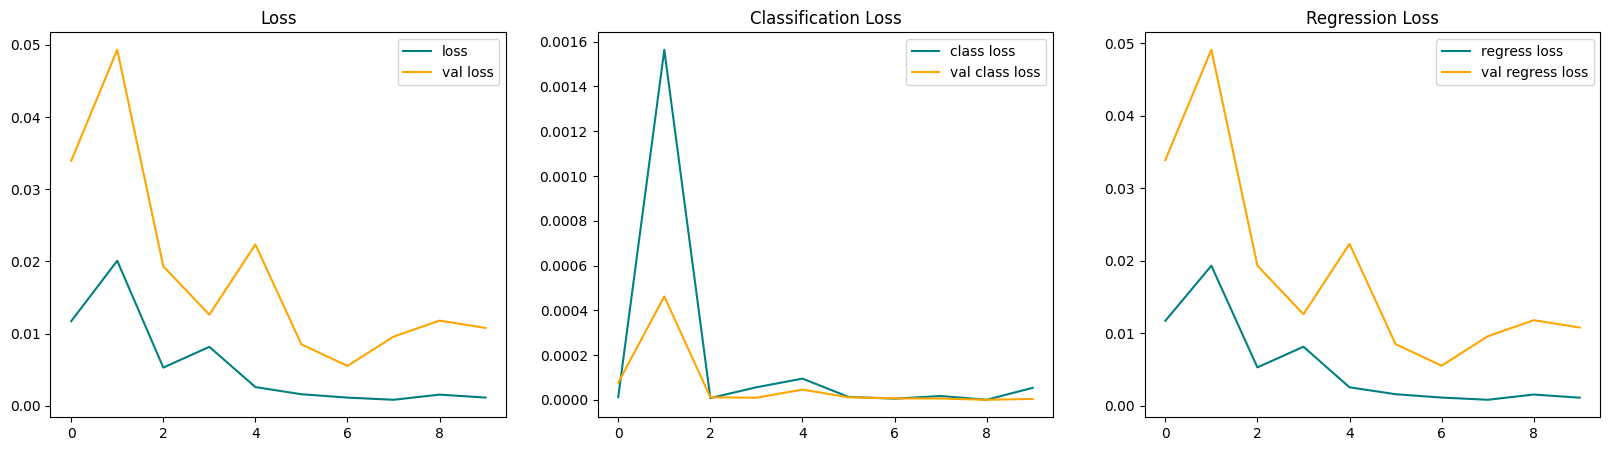

In [113]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

# 11. Make Predictions

### 11.1 Make Predictions on Test Set

In [114]:
test_data = test.as_numpy_iterator()

In [120]:
test_sample = test_data.next()

In [121]:
yhat = facetracker.predict(test_sample[0])

1/1 [==============================] - 0s 55ms/step


### 11.2 Save the Model

In [ ]:
from tensorflow.keras.models import load_model

In [125]:
facetracker.save('D:/Project/Face_detection/face_detection.h5')